## Initializing filters on known motifs

In the scenario where data is scarse, it is often useful to initialize the filters of the first convolutional layer to some known position weights matrices (PWM's). That way, the model already starts with a parameter configuration much closer to the 'right' one.

Concise provides access to 2 PWM databases:

- transcription factors from ENCODE (2067 PWMs)
- rna-binding proteins from ATtrACT (1583 PWMs).

### Find the motif of interest

Each PWM database is provided as a module under `concise.data`. It provides two functions:

- `concise.data.<db>.get_metadata()` - returns a pandas.DataFrame with metadata information about each PWM 
- `concise.data.<db>.get_pwm_list()` - given a list of PWM ids, return a list with `concise.utils.pwm.PWM` instances

#### Metadata tables

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
# RBP PWM's
from concise.data import attract

dfa = attract.get_metadata()
dfa

,PWM_id,Gene_name,Gene_id,Mutated,Organism,Motif,Len,Experiment_description,Database,Pubmed,Experiment_description.1,Family,Score
0,519,3IVK,3IVK,no,Mus_musculus,GAAACA,6,X-RAY DIFFRACTION,PDB,19965478,X-RAY DIFFRACTION,NaN,1.000000**
1,574,3IVK,3IVK,no,Mus_musculus,UGGG,4,X-RAY DIFFRACTION,PDB,19965478,X-RAY DIFFRACTION,NaN,1.000000**
2,464,4KZD,4KZD,no,Mus_musculus,GAAAC,5,X-RAY DIFFRACTION,PDB,24952597,X-RAY DIFFRACTION,NaN,1.000000**
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4879,1396,HNRNPAB,ENSG00000197451,no,Homo_sapiens,AUAGCA,6,In vitro splicing assays,AEDB,12426391,other,RRM,1.000000**
4880,1397,HNRNPA1,ENSG00000135486,no,Homo_sapiens,UAGG,4,Immunoprecipitation;U...,AEDB,15506926,UV cross-linking,RRM,1.000000**
4881,1398,PTBP1,ENSG00000011304,no,Homo_sapiens,UUCUUC,6,In vivo splicing assa...,AEDB,14966131,UV cross-linking,RRM,1.000000**


In [4]:
# TF PWM's
from concise.data import encode

dfe = encode.get_metadata()
dfe

,motif_name,consensus
0,AFP_1,ATTAACTACAC
1,AHR::ARNT::HIF1A_1,TGCGTGCGG
2,AHR::ARNT_1,TAAGGGTTGCGTGCCC
...,...,...
2064,ZSCAN4_3,TGCACACACTGAAAA
2065,fake_AACGSSAA,AACGCCAA
2066,fake_AAGCSSAA,AAGCCCAA


Let's choose PUM2 PWM (RBP in Human):

In [5]:
dfa_pum2 = dfa[dfa.Gene_name.str.match("PUM2") & \
               dfa.Organism.str.match("Homo_sapiens")]
dfa_pum2

,PWM_id,Gene_name,Gene_id,Mutated,Organism,Motif,Len,Experiment_description,Database,Pubmed,Experiment_description.1,Family,Score
2603,503,PUM2,ENSG00000055917,no,Homo_sapiens,UGUAAAUA,8,X-RAY DIFFRACTION,PDB,21397187,X-RAY DIFFRACTION,PUF,1.000000**
2604,361,PUM2,ENSG00000055917,no,Homo_sapiens,UGUACAUC,8,X-RAY DIFFRACTION,PDB,21397187,X-RAY DIFFRACTION,PUF,1.000000**
2605,514,PUM2,ENSG00000055917,no,Homo_sapiens,UGUAGAUA,8,X-RAY DIFFRACTION,PDB,21397187,X-RAY DIFFRACTION,PUF,1.000000**
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2613,107,PUM2,ENSG00000055917,no,Homo_sapiens,UGUAUAUA,8,PAR-clip,C,20371350,genome-wide in vivo i...,PUF,0.250000**
2614,107,PUM2,ENSG00000055917,no,Homo_sapiens,UGUACAUA,8,PAR-clip,C,20371350,genome-wide in vivo i...,PUF,0.250000**
2615,107,PUM2,ENSG00000055917,no,Homo_sapiens,UGUAGAUA,8,PAR-clip,C,20371350,genome-wide in vivo i...,PUF,0.250000**


#### Visualization - PWM class

The `PWM` class provides a method `plotPWM` to visualize the PWM.

In [6]:
# Visualize the PUM2 Motifs from different experiments
from concise.utils.pwm import PWM
dfa_pum2_uniq = dfa_pum2[["Experiment_description", "PWM_id"]].drop_duplicates()
pwm_list = attract.get_pwm_list(dfa_pum2_uniq.PWM_id)

PWM_id: 503 ; Experiment_description: X-RAY DIFFRACTION


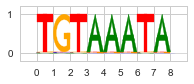

PWM_id: 361 ; Experiment_description: X-RAY DIFFRACTION


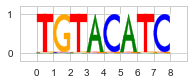

PWM_id: 514 ; Experiment_description: X-RAY DIFFRACTION


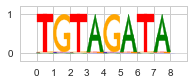

PWM_id: 116 ; Experiment_description: RIP-chip


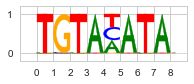

PWM_id: 129 ; Experiment_description: genome-wide in vivo immunoprecipitation


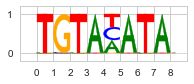

PWM_id: 107 ; Experiment_description: PAR-clip


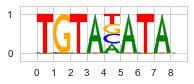

In [7]:
for i, pwm in enumerate(pwm_list):
    print("PWM_id:", pwm.name, "; Experiment_description:", dfa_pum2_uniq.Experiment_description.iloc[i])
    pwm.plotPWM(figsize=(3,1))

We can select the PWM with id 129.

In [8]:
pwm_list = [pwm for pwm in pwm_list if pwm.name == "129"]

In [9]:
pwm_list

[PWM(name: 129, consensus: TGTAAATA)]

### Initialize the conv filters with PWM values

In [10]:
import concise.layers as cl
import keras.layers as kl
import concise.initializers as ci
import concise.regularizers as cr
from keras.callbacks import EarlyStopping
from concise.preprocessing import encodeDNA
from keras.models import Model, load_model
from keras.optimizers import Adam

In [12]:
# get the data
def load(split="train", st=None):
    dt = pd.read_csv("../data/RBP/PUM2_{0}.csv".format(split))
    # DNA/RNA sequence
    xseq = encodeDNA(dt.seq) # list of sequences -> np.ndarray
    # response variable
    y = dt.binding_site.as_matrix().reshape((-1, 1)).astype("float")
    return {"seq": xseq}, y

train, valid, test = load("train"), load("valid"), load("test")

# deduce sequence length
seq_length = train[0]["seq"].shape[1]

In [14]:
# define the model
def model(train, filters=1, kernel_size=9, pwm_list=None, lr=0.001):
    seq_length = train[0]["seq"].shape[1]
    if pwm_list is None:
        kinit = "glorot_uniform"
        binit = "zeros"
    else:
        kinit = ci.PSSMKernelInitializer(pwm_list, add_noise_before_Pwm2Pssm=True)
        binit = "zeros"
        
    # sequence
    in_dna = cl.InputDNA(seq_length=seq_length, name="seq")
    x = cl.ConvDNA(filters=filters, 
                   kernel_size=kernel_size, 
                   activation="relu",
                   kernel_initializer=kinit,
                   bias_initializer=binit,
                   name="conv1")(in_dna)
    x = kl.AveragePooling1D(pool_size=4)(x)
    x = kl.Flatten()(x)
    
    x = kl.Dense(units=1)(x)
    m = Model(in_dna, x)
    m.compile(Adam(lr=lr), loss="binary_crossentropy", metrics=["acc"])
    return m

**TODO** - check if this is true

`ci.PSSMKernelInitializer` will set the filters of the first convolutional layer to the values of the position-specific scoring matrix (PSSM):

$$ pssm_{ij} = log \frac{pwm_{ij}}{b_j} \;,$$

where $b_j$ is the background probability of observing base $j$.

We add gaussian noise to each individual filter. Let's visualize the filters:

In [15]:
# create two models: with and without PWM initialization
m_rand_init = model(train, filters=3, pwm_list=None) # random initialization
m_pwm_init = model(train, filters=3, pwm_list=pwm_list) # motif initialization

Random initialization:
filter index: 0


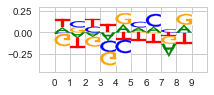

filter index: 1


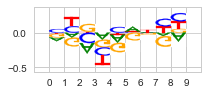

filter index: 2


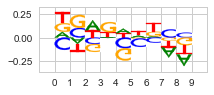

In [16]:
print("Random initialization:")
m_rand_init.get_layer("conv1").plot_weights(figsize=(3, 1.2))

Known PWM initialization:
filter index: 0


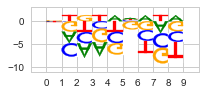

filter index: 1


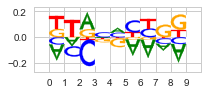

filter index: 2


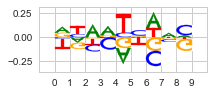

In [17]:
print("Known PWM initialization:")
m_pwm_init.get_layer("conv1").plot_weights(figsize=(3, 1.2))

In [18]:
# train the models
m_rand_init.fit(train[0], train[1], epochs=50, validation_data=valid, 
                verbose=2,
                callbacks=[EarlyStopping(patience=5)])

Train on 17713 samples, validate on 4881 samples
Epoch 1/50
1s - loss: 0.5931 - acc: 0.7957 - val_loss: 0.5082 - val_acc: 0.7992
Epoch 2/50
0s - loss: 0.5023 - acc: 0.7958 - val_loss: 0.4885 - val_acc: 0.7990
Epoch 3/50
0s - loss: 0.4868 - acc: 0.7957 - val_loss: 0.4794 - val_acc: 0.7996
Epoch 4/50
0s - loss: 0.4795 - acc: 0.7960 - val_loss: 0.4728 - val_acc: 0.8009
Epoch 5/50
0s - loss: 0.4770 - acc: 0.7962 - val_loss: 0.4739 - val_acc: 0.8009
Epoch 6/50
0s - loss: 0.4712 - acc: 0.7969 - val_loss: 0.4646 - val_acc: 0.8027
Epoch 7/50
0s - loss: 0.4633 - acc: 0.7976 - val_loss: 0.4533 - val_acc: 0.8023
Epoch 8/50
0s - loss: 0.4495 - acc: 0.8011 - val_loss: 0.4353 - val_acc: 0.8062
Epoch 9/50
0s - loss: 0.4372 - acc: 0.8051 - val_loss: 0.4322 - val_acc: 0.8031
Epoch 10/50
0s - loss: 0.4335 - acc: 0.8090 - val_loss: 0.4270 - val_acc: 0.8033
Epoch 11/50
0s - loss: 0.4313 - acc: 0.8107 - val_loss: 0.4381 - val_acc: 0.8144
Epoch 12/50
0s - loss: 0.4245 - acc: 0.8113 - val_loss: 0.4390 - val_

In [19]:
m_pwm_init.fit(train[0], train[1], epochs=50, validation_data=valid, 
                verbose=2,
                callbacks=[EarlyStopping(patience=5)])

Train on 17713 samples, validate on 4881 samples
Epoch 1/50
1s - loss: 0.7954 - acc: 0.7628 - val_loss: 0.6350 - val_acc: 0.8007
Epoch 2/50
1s - loss: 0.5508 - acc: 0.8014 - val_loss: 0.5144 - val_acc: 0.8052
Epoch 3/50
1s - loss: 0.4755 - acc: 0.8117 - val_loss: 0.4871 - val_acc: 0.8070
Epoch 4/50
1s - loss: 0.4426 - acc: 0.8165 - val_loss: 0.4316 - val_acc: 0.8181
Epoch 5/50
0s - loss: 0.4269 - acc: 0.8230 - val_loss: 0.4251 - val_acc: 0.8242
Epoch 6/50
0s - loss: 0.4154 - acc: 0.8299 - val_loss: 0.4145 - val_acc: 0.8269
Epoch 7/50
1s - loss: 0.4081 - acc: 0.8354 - val_loss: 0.4077 - val_acc: 0.8312
Epoch 8/50
1s - loss: 0.4012 - acc: 0.8396 - val_loss: 0.4032 - val_acc: 0.8361
Epoch 9/50
1s - loss: 0.3920 - acc: 0.8436 - val_loss: 0.3972 - val_acc: 0.8379
Epoch 10/50
0s - loss: 0.3872 - acc: 0.8465 - val_loss: 0.4085 - val_acc: 0.8408
Epoch 11/50
1s - loss: 0.3837 - acc: 0.8480 - val_loss: 0.4049 - val_acc: 0.8406
Epoch 12/50
1s - loss: 0.3769 - acc: 0.8508 - val_loss: 0.3960 - val_

### Test-set performance

In [20]:
import concise.eval_metrics as cem

In [21]:
# performance on the test-set
# Random initialization
print("Random intiailzation auPR:", cem.auprc(test[1], m_rand_init.predict(test[0])))
# PWM initialization
print("Known PWM initialization auPR:", cem.auprc(test[1], m_pwm_init.predict(test[0])))

Random intiailzation auPR: 0.635598660178
Known PWM initialization auPR: 0.724295058122


### Filter visualization

filter index: 0


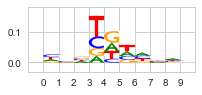

filter index: 1


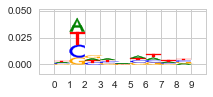

filter index: 2


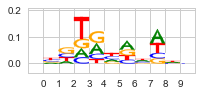

In [22]:
m_rand_init.get_layer("conv1").plot_weights(plot_type="motif_pwm_info", figsize=(3, 1.2))

filter index: 0


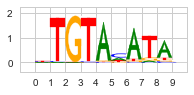

filter index: 1


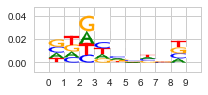

filter index: 2


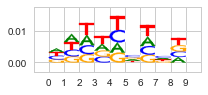

In [23]:
m_pwm_init.get_layer("conv1").plot_weights(plot_type="motif_pwm_info", figsize=(3, 1.2))

## Benefits of motif initialization

- Interpretatbility
  - we can use fewer filters and know that the major effect will be captured by the first filters
    - handy when studying the model parameters
- Better predictive performance
- More stable training